**Unzip the Data Folder**

*   Note: Please upload the data folder to content first



In [ ]:
!unzip uw-cs480-fall20.zip

**Read CSV file and prepare the Train Data and Test Data**

In [ ]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# prepare train dataset
train_data = pd.read_csv("train.csv")
train_category = train_data.category
train_id = train_data.id
classification = (pd.unique(train_category)).tolist()
y = list(map(lambda c: np.array([classification.index(c)]), train_category))
y_train = np.array(y)
train_img = []
for label in train_id:
  img = mpimg.imread('suffled-images/shuffled-images/{}.jpg'.format(label))
  train_img.append(img)
x_train = np.array(train_img)

# prepare test dataset
test_data = pd.read_csv("test.csv")
test_id = test_data.id
test_img = []
for label in test_id:
  img = mpimg.imread('suffled-images/shuffled-images/{}.jpg'.format(label))
  test_img.append(img)
x_test= np.array(test_img)



**Normalize each dataset and prepare the Training set and Validating set**

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
x_train shape: (21627, 80, 60, 3)
y_train shape: (21627, 1)
x_test shape: (21628, 80, 60, 3)
The image label is:  [0]
The image class is:  Scarves
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]
The one hot label is: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]


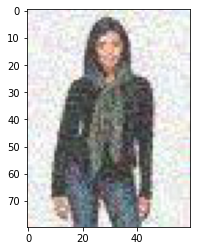

In [ ]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical

# parameters for this script
batch_size = 32
num_classes = 27
epochs = 50
data_augmentation = False

# Print the data type of x_train
print(type(x_train))
# Print the data type of y_train
print(type(y_train))
# Print the data type of x_test
print(type(x_test))

# Get the shape of x_train
print('x_train shape:', x_train.shape)
# Get the shape of y_train
print('y_train shape:', y_train.shape)
# Get the shape of x_train
print('x_test shape:', x_test.shape)

index = 0
x_train[index]
img = plt.imshow(x_train[index])
print('The image label is: ', y_train[index])
#Print the image class
print('The image class is: ', classification[y_train[index][0]])

# Convert to categorical
y_train_one_hot = to_categorical(y_train)
print(y_train_one_hot)
print('The one hot label is:', y_train_one_hot[0])

# normalize the data
x_train = x_train / 255
x_test = x_test / 255

# partition training set into training and validation set
x_validate = x_train[17300:,:]
x_train = x_train[:17300,:]
y_validate = y_train_one_hot[17300:,:]
y_train = y_train_one_hot[:17300,:]

**Prepare the CNN model and train with the dataset**

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 78, 58, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 78, 58, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 76, 56, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 76, 56, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 38, 28, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 38, 28, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 26, 64)        1

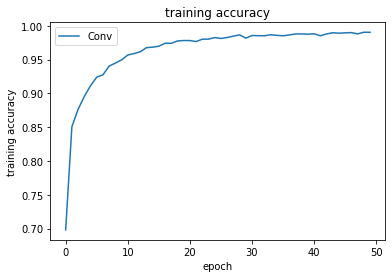

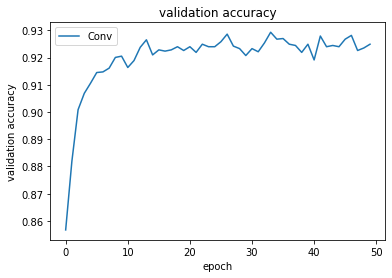

In [ ]:
# Define a convolutional neural network
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(80, 60, 3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.Adam()

# Compile the model before using it
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
print(model.summary())

# create a callback that will save the best model while training
save_best_model = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

# train without data augmentation
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(x_validate, y_validate),
                        shuffle=True,
                        callbacks=[save_best_model])

# train with data augmentation
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                        steps_per_epoch=math.ceil(x_train.shape[0]/batch_size),
                        epochs=epochs,
                        validation_data=(x_validate, y_validate),
                        callbacks=[save_best_model])
    
# Plot training accuracy
plt.plot(history.history['accuracy'])
plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(['Conv'], loc='upper left')
plt.show()

# Plot validation accuracy
plt.plot(history.history['val_accuracy'])
plt.title('validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(['Conv'], loc='upper left')
plt.show()


**Use the CNN model to make prediction on test set**

In [ ]:
# Evaluate the best model saved (i.e., model with best validation accuracy) on the test set
saved_model = load_model('best_model.h5')
predictions = saved_model.predict(x_test)
print(predictions)


NameError: ignored

In [ ]:
classes = np.argmax(predictions, axis = 1)
predicted_categories = list(map(lambda i: classification[i], classes))
result = {"id":test_id,  "category":predicted_categories}
df = pd.DataFrame(result)
df.to_csv('submission.csv', index=False)

**Test your own image**

Saving 1635.jpg to 1635 (2).jpg
[[7.4560354e-05 3.0735028e-13 1.1626058e-08 7.0863458e-17 3.1214048e-12
  9.9991500e-01 4.4751161e-11 6.6367862e-09 7.4068471e-06 1.9236698e-15
  3.1755638e-09 5.6576410e-10 2.6396629e-10 3.3420237e-22 9.6127022e-26
  3.6633082e-07 1.8408586e-15 4.1349688e-12 6.6583935e-12 9.7396163e-23
  2.1072459e-10 3.2682237e-08 6.9977162e-08 6.4990066e-23 2.5008303e-06
  2.7631220e-13 3.2758213e-14]]
[5, 0, 8, 2, 7, 6, 4, 1, 9, 3]
Socks : 99.99 %
Scarves : 0.01 %
Dress : 0.0 %
Topwear : 0.0 %
Watches : 0.0 %


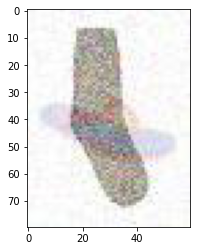

In [ ]:
# Test the data
from google.colab import files # Use to load data on Google Colab
uploaded = files.upload() # Use to load data on Google Colab
new_image = plt.imread("1635.jpg") #Read in the image (3, 14, 20)
img = plt.imshow(new_image)

from skimage.transform import resize
resized_image = resize(new_image, (80,60,3))
img = plt.imshow(resized_image)

predictions = model.predict(np.array([resized_image]))
list_index = [0,1,2,3,4,5,6,7,8,9]
x = predictions
for i in range(10):
  for j in range(10):
    if x[0][list_index[i]] > x[0][list_index[j]]:
      temp = list_index[i]
      list_index[i] = list_index[j]
      list_index[j] = temp
#Show the sorted labels in order from highest probability to lowest
print(list_index)
i=0
for i in range(5):
  print(classification[list_index[i]], ':', round(predictions[0][list_index[i]] * 100, 2), '%')